In [31]:
# import dependencies
import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
from torchvision import datasets
import numpy as np, cv2
import matplotlib.pyplot as plt
from glob import glob
from imgaug import augmenters as iaa
import torch.nn as nn
from torchsummary import summary

In [13]:
# define augmented data method
tfm = iaa.Sequential(iaa.Resize(28))
class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    def __len__(self): return len(self.files)
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(cv2.imread(f)[:,:,0])
        im = im[None]
        cl = f.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - im/255).float(), torch.tensor([cl]).float()

In [24]:
folder = '/Users/macbookpro/Desktop/AI SIBERIA/Computer Vision /Chapter-4/data/all/*'

In [25]:
data = XO(folder)

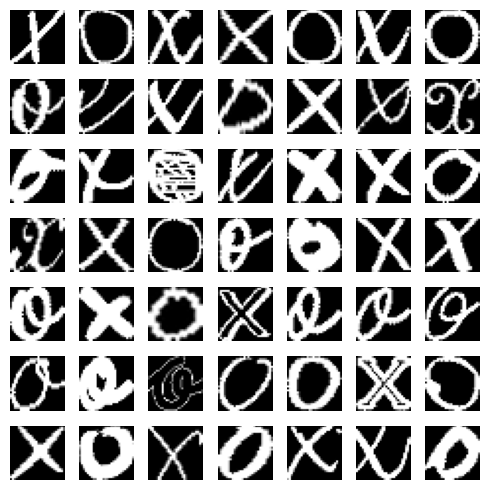

In [28]:
R, C = 7, 7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(1000)
        im, label = data[ix]
        print()
        plot_cell.imshow(im[0], cmap='gray')
plt.tight_layout()

In [33]:
# Define model architecture, loss function and the optimizer
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )
    
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [34]:
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 1]                   257
├─Sigmoid: 1-11                          [-1, 1]                   --
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass s

In [35]:
# define a function for training on batches

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(), is_correct

In [36]:
# Define Dataloader where input is the Dataset class
trn_dl = DataLoader(data, batch_size=32, drop_last=True)

In [37]:
# Train the model over 5 epochs
for epoch in range(5):
    print(epoch)
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)

0
1
2
3
4


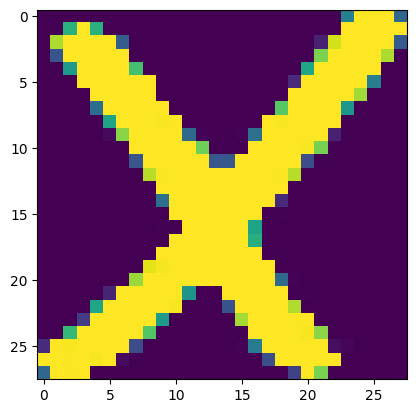

In [38]:
# Fetch an image to check what the filters learns about the image
im, c = trn_dl.dataset[2]
plt.imshow(im[0])
plt.show()

In [40]:
# pass the image through the trained model and fetch the output of the first
# layer. Then store it in the intermediate_output variable

first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

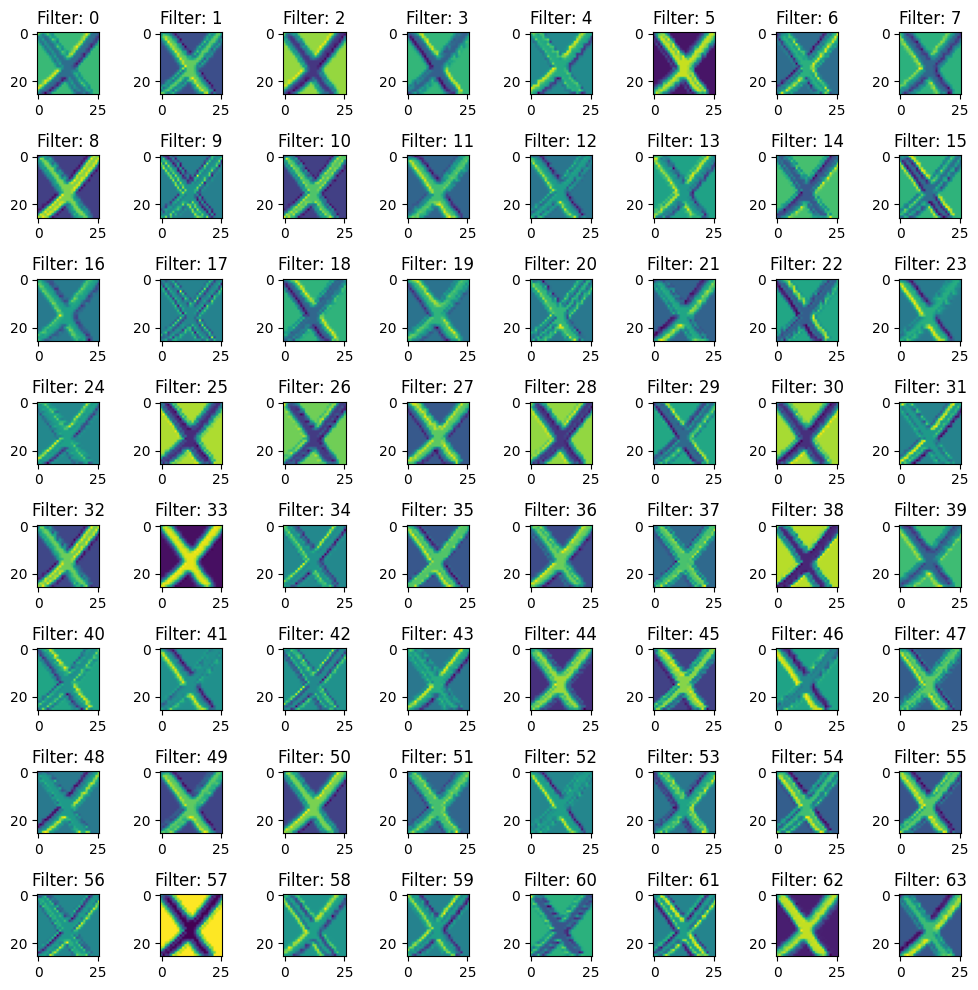

In [45]:
# plot the output of the 64 filters. Each channel in intermediate_output is the output convolution for each filter
fig, ax = plt.subplots(8, 8, figsize=(10,10))
for ix, axis in enumerate(ax.flat):
    axis.set_title("Filter: "+str(ix))
    axis.imshow(intermediate_output[ix])
plt.tight_layout()
plt.show()
